In [534]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [535]:
import kagglehub

path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\sjnik\.cache\kagglehub\datasets\kundanbedmutha\exam-score-prediction-dataset\versions\2


In [536]:
import zipfile
import os
folder_path = r"C:\Users\sjnik\.cache\kagglehub\datasets\kundanbedmutha\exam-score-prediction-dataset\versions\2"

for file in os.listdir(folder_path):
    if file.endswith(".zip"):
        zip_path = os.path.join(folder_path, file)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        print(f"Extracted: {file}")
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        csv_path = os.path.join(folder_path, file)
        df = pd.read_csv(csv_path)
        print(f"Successfully loaded: {file}")
        break

Successfully loaded: Exam_Score_Prediction.csv


In [537]:
df.head(10)

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7
5,6,23,male,b.tech,3.48,65.4,yes,4.2,good,mixed,low,moderate,58.2
6,7,17,female,b.tech,1.35,69.0,yes,7.4,average,online videos,high,hard,53.7
7,8,22,male,b.sc,5.48,51.1,yes,8.2,poor,self-study,low,moderate,47.3
8,9,18,other,bca,2.89,92.0,yes,6.6,poor,self-study,low,easy,44.9
9,10,17,male,bba,6.77,44.8,yes,9.8,average,group study,high,moderate,77.7


Exploratory Data Analysis

In [538]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


In [539]:
df.describe()

,student_id,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,10000.504600,20.473300,4.007604,70.017365,7.00856,62.513225
std,5773.654959,2.284458,2.308313,17.282262,1.73209,18.908491
min,1.000000,17.000000,0.080000,40.600000,4.10000,19.599000
25%,5000.750000,18.000000,2.000000,55.100000,5.50000,48.800000
50%,10000.500000,20.000000,4.040000,69.900000,7.00000,62.600000
75%,15000.250000,22.000000,6.000000,85.000000,8.50000,76.300000
max,20001.000000,24.000000,7.910000,99.400000,9.90000,100.000000


In [540]:
df["study_method"].unique()

array(['coaching', 'online videos', 'mixed', 'self-study', 'group study'],
      dtype=object)

______________________________________________________________________________________________________________________________________________________

Correlation beteween categorical variables

In [541]:
import scipy.stats as stats

cat_cols = df.select_dtypes(include=['object', 'category']).columns

f_scores = {}
for col in cat_cols:

    groups = [group['exam_score'].values for name, group in df.groupby(col)]

    f_stat, p_val = stats.f_oneway(*groups)
    f_scores[col] = f_stat

anova_df = pd.DataFrame.from_dict(f_scores, orient='index', columns=['F-Score'])
anova_df = anova_df.sort_values('F-Score', ascending=False)

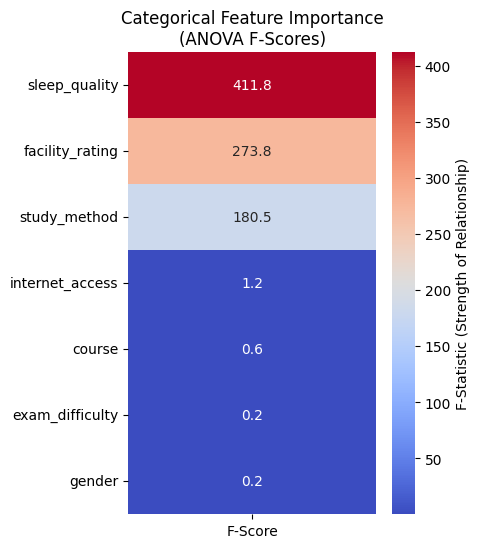

In [542]:
plt.figure(figsize=(4, 6))  

sns.heatmap(anova_df, 
            annot=True,      
            cmap='coolwarm',  
            fmt='.1f',        
            cbar_kws={'label': 'F-Statistic (Strength of Relationship)'})

plt.title('Categorical Feature Importance\n(ANOVA F-Scores)')
plt.show()

From the ANOVA results it is evident that sleep_quality, facility_rating and study_method affects the exam score significantly

_____________________________________________________________________________________________________________________________________________________

Correlation beteween numerical variables

In [543]:
new_df = df.drop(columns=['student_id'])
df_n=new_df.select_dtypes('number')
df_n.corr()

,age,study_hours,class_attendance,sleep_hours,exam_score
age,1.000000,0.002955,0.008449,-0.000385,0.006522
study_hours,0.002955,1.000000,-0.001645,-0.004533,0.717788
class_attendance,0.008449,-0.001645,1.000000,0.007187,0.308850
sleep_hours,-0.000385,-0.004533,0.007187,1.000000,0.133222
exam_score,0.006522,0.717788,0.308850,0.133222,1.000000


<Axes: >

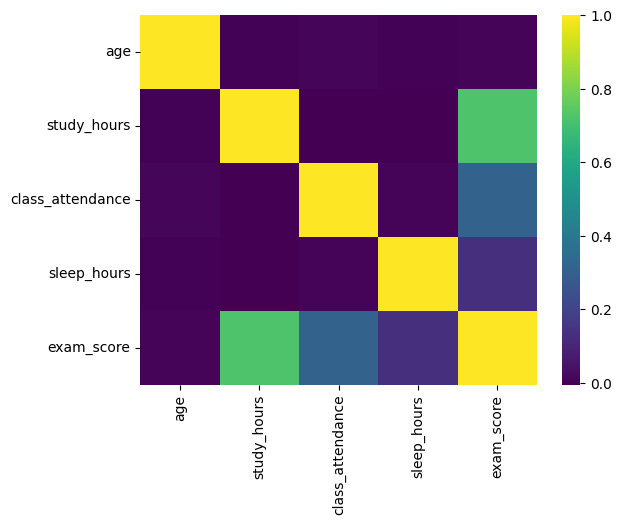

In [544]:
sns.heatmap(df_n.corr(),cmap='viridis')

From the correlation heat map its evident that 
study_hours,class_attendance, and sleep_hours have great impact on exam scores the former two impacting the most

____________________________________________________________________________________________________________________________________________________________

HEXBIN PLOTS

Darker hexagons mean more students

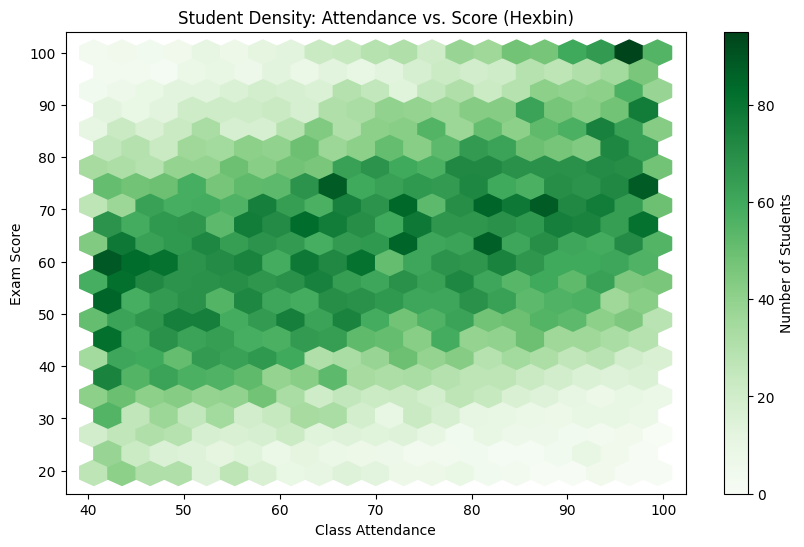

In [545]:
# Hexbin plot: Attendance vs Exam Score
plt.figure(figsize=(10, 6))
plt.hexbin(df['class_attendance'], df['exam_score'], gridsize=20, cmap='Greens')
plt.colorbar(label='Number of Students')
plt.title('Student Density: Attendance vs. Score (Hexbin)')
plt.xlabel('Class Attendance')
plt.ylabel('Exam Score')
plt.show()

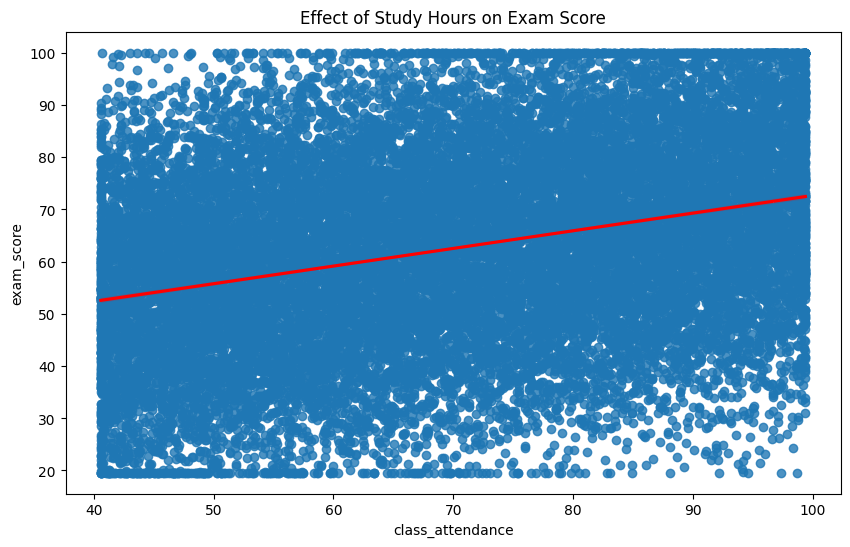

In [546]:
plt.figure(figsize=(10, 6))

sns.regplot(data=df, x='class_attendance', y='exam_score', line_kws={'color': 'red'})
plt.title('Effect of Study Hours on Exam Score')
plt.show()

<Axes: xlabel='class_attendance', ylabel='exam_score'>

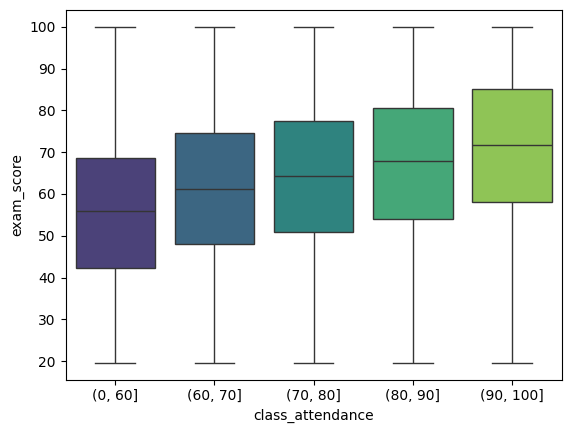

In [547]:
sns.boxplot(x=pd.cut(df['class_attendance'], bins=[0, 60, 70, 80, 90, 100]), 
            y=df['exam_score'], 
            hue=pd.cut(df['class_attendance'], bins=[0, 60, 70, 80, 90, 100]),
            legend=False,
            palette='viridis')

From the boxplot the median score of students in all bins follow increasing order hence it can be said that Higher attendance typically leads 
Higher scores

_________________________________________________________________________________________________________________________________________________________________________

Effect of Study time on Exam score

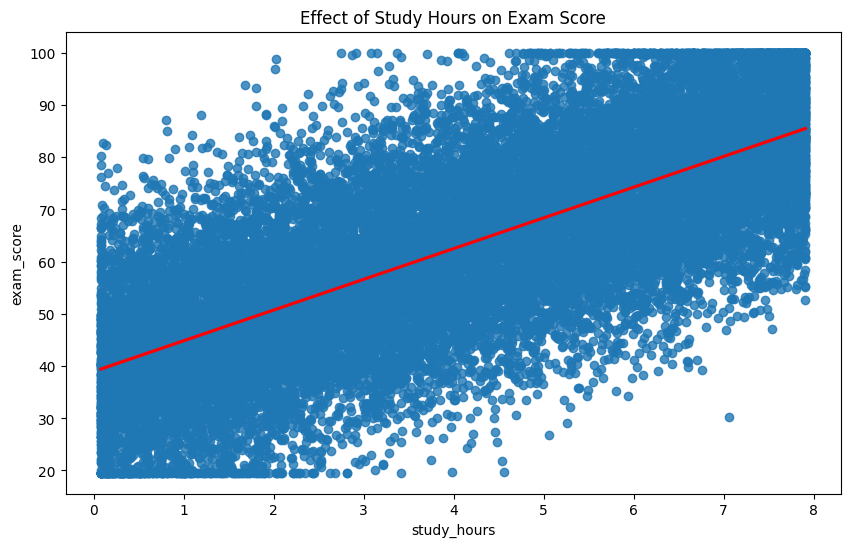

In [548]:
plt.figure(figsize=(10, 6))

sns.regplot(data=df, x='study_hours', y='exam_score', line_kws={'color': 'red'})
plt.title('Effect of Study Hours on Exam Score')
plt.show()

array([[<Axes: title={'center': 'student_id'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'study_hours'}>,
        <Axes: title={'center': 'class_attendance'}>],
       [<Axes: title={'center': 'sleep_hours'}>,
        <Axes: title={'center': 'exam_score'}>]], dtype=object)

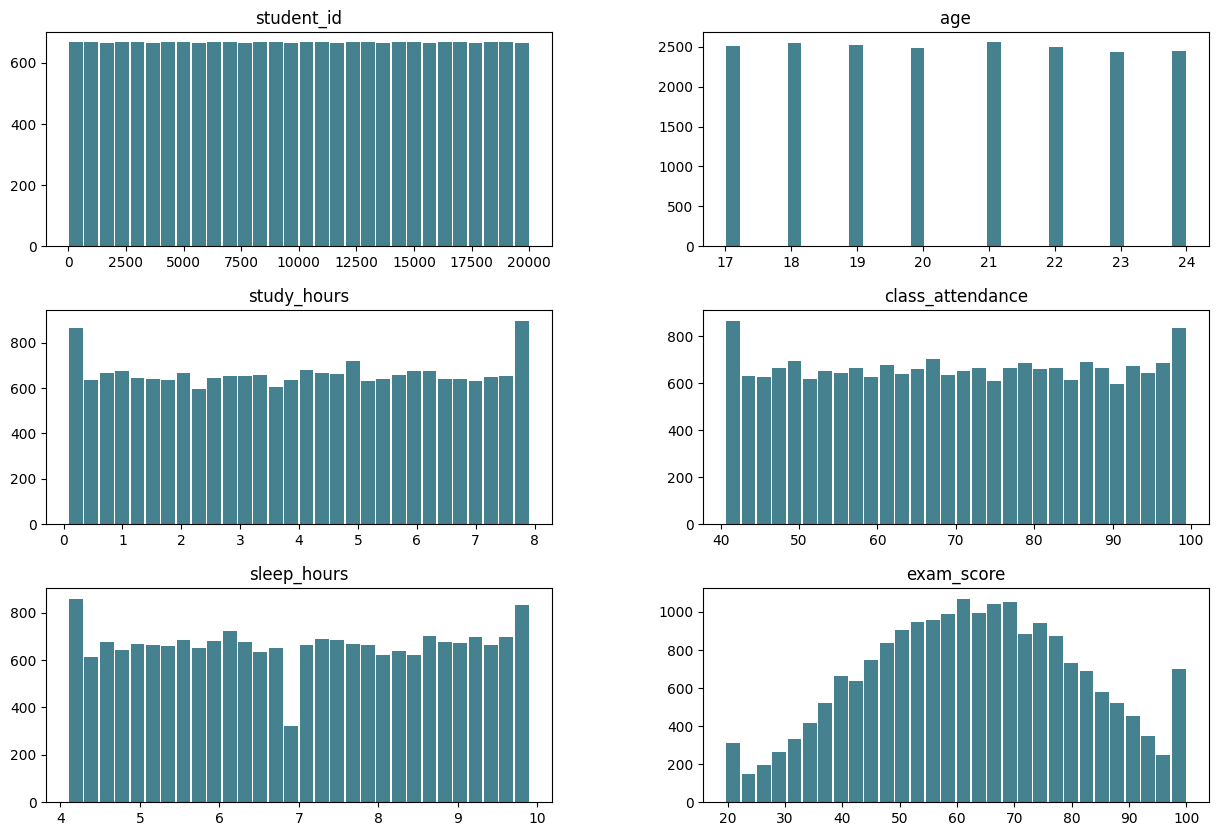

In [549]:
df.hist(bins=30, figsize=(15, 10), rwidth=0.9, color='#45818e', grid=False)

The Correleation values and regression plots indicates that study hours has more linear correlation than class attendance and sleep hours

______________________________________________________________________________________________________________________________________________________________________________

Impact of 'facility_rating' on 'exam_score'

In [550]:
facility=df.groupby('facility_rating',as_index=False)["exam_score"].describe()
facility

,facility_rating,count,mean,std,min,25%,50%,75%,max
0,high,6602.0,66.165916,18.554515,19.599,52.7,66.50,79.8,100.0
1,low,6638.0,58.594346,18.796320,19.599,44.8,58.80,72.1,100.0
2,medium,6760.0,62.794061,18.615776,19.599,49.4,62.95,76.4,100.0


([<matplotlib.patches.Wedge at 0x21542d7afd0>,
 [Text(-0.946992198455366, 0.559647903654318, 'high'),
  Text(-0.02729744680655092, -1.099661243018887, 'low'),
  Text(0.9605886999385768, 0.5359751389293306, 'medium')],
 [Text(-0.5165411991574723, 0.3052624929023553, '33.0%'),
  Text(-0.014889516439936863, -0.5998152234648474, '33.2%'),
  Text(0.523957472693769, 0.2923500757796348, '33.8%')])

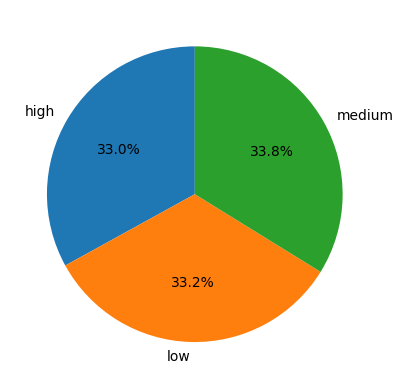

In [551]:
plt.pie(facility['count'],labels=facility['facility_rating'],autopct='%1.1f%%',startangle = 90)

The majority of students (approx 34%) are enrolled in institutions with 'Medium' rated facilities.

<Axes: xlabel='facility_rating', ylabel='mean'>

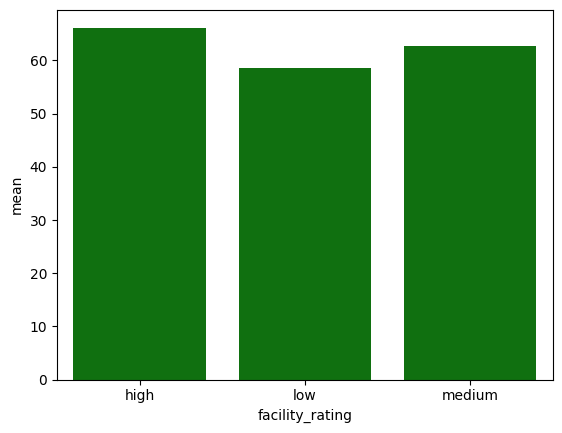

In [552]:
sns.barplot(x='facility_rating',y='mean',color='green',data=facility)

In [553]:
facility_mapping = {'low': 0, 'medium': 1, 'high': 2}
facility_col= df['facility_rating'].map(facility_mapping)
facility_col

0        0
1        1
2        2
3        0
4        0
        ..
19995    0
19996    1
19997    0
19998    1
19999    1
Name: facility_rating, Length: 20000, dtype: int64

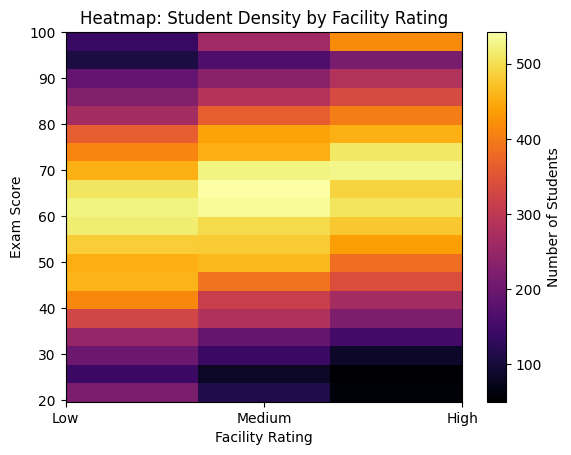

In [554]:
h=plt.hist2d(facility_col, df['exam_score'], bins=[3, 20], cmap='inferno')
cbar = plt.colorbar(h[3])
cbar.set_label('Number of Students')
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.title('Heatmap: Student Density by Facility Rating')
plt.xlabel('Facility Rating')
plt.ylabel('Exam Score')
plt.show()

A preliminary review of the data samples suggests a strong positive association between facility_rating and exam_score, where students with access to 'High' rated facilities consistently outperform those in 'Low' rated environments.

In [555]:
#comparing Facility Ratings across all course
cross_tab = pd.crosstab(df['course'], df['facility_rating'])
cross_tab

facility_rating,high,low,medium
course,,,
b.com,915,961,988
b.sc,962,968,948
b.tech,952,932,914
ba,957,955,984
bba,949,937,950
bca,931,978,993
diploma,936,907,983


<Axes: xlabel='facility_rating', ylabel='course'>

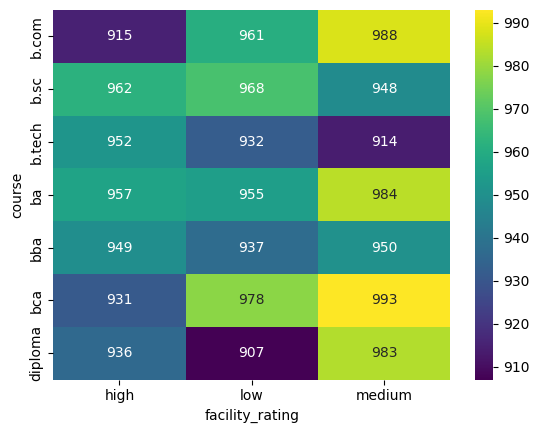

In [556]:
sns.heatmap(pd.crosstab(df['course'], df['facility_rating']), 
            annot=True,     # Show the actual numbers
            fmt='d',        # Format as integers (no decimals)
            cmap='viridis')

The majority of students have access to medium-rated facilities.Among which BCA course having the most.

In [557]:
difficulty_cross_tab=pd.crosstab(df["course"],df["exam_difficulty"])
difficulty_cross_tab=difficulty_cross_tab[["easy","moderate","hard"]]

<Axes: xlabel='exam_difficulty', ylabel='course'>

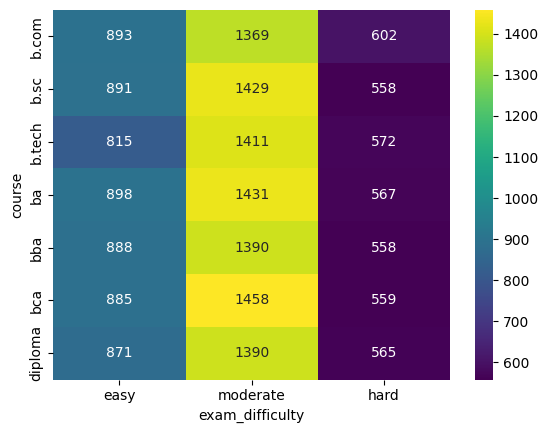

In [558]:
sns.heatmap(difficulty_cross_tab, 
            annot=True,     # Show the actual numbers
            fmt='d',        # Format as integers (no decimals)
            cmap='viridis')

From the above heat map its evident that majority of the students from all courses finds the exam as moderate and small number of students finds it hard

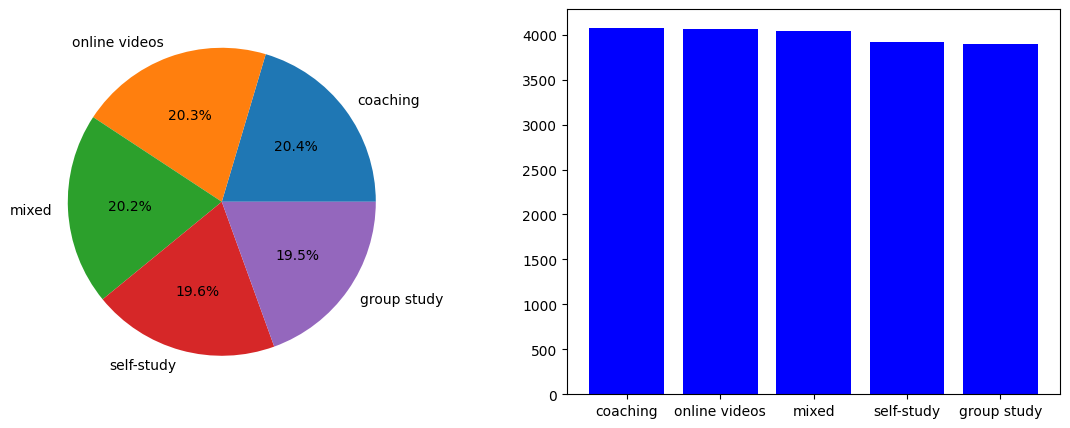

In [559]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].pie(df["study_method"].value_counts(),labels=df["study_method"].unique(),autopct='%1.1f%%')
ax[1].bar(df["study_method"].unique(),df["study_method"].value_counts(),color='blue')
plt.show()

Students are approximately equally distributed among all 5 study methods evident from pie chart

_______________________________________________________________________________________________________________________________________________________

Number of students using different study mrthod from  different courses

In [560]:
pd.crosstab(df["study_method"],df["course"])

course,b.com,b.sc,b.tech,ba,bba,bca,diploma
study_method,,,,,,,
coaching,585,563,535,563,595,595,600
group study,547,586,565,547,571,558,548
mixed,580,534,539,583,549,572,537
online videos,580,602,552,606,559,587,583
self-study,572,593,607,597,562,590,558


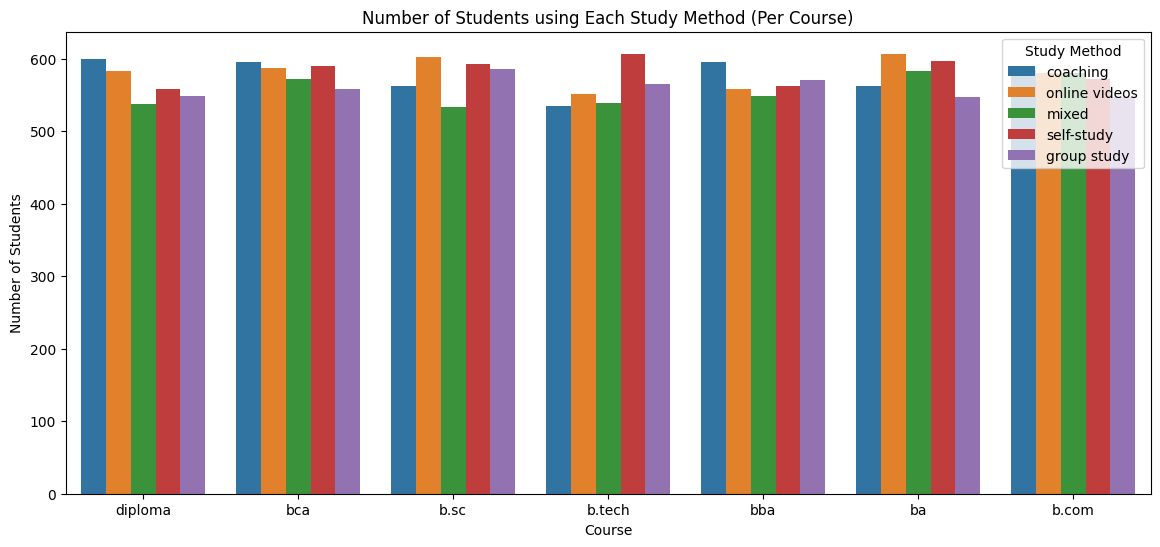

In [561]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='course', hue='study_method')

plt.title('Number of Students using Each Study Method (Per Course)')
plt.ylabel('Number of Students')
plt.xlabel('Course')
plt.legend(title='Study Method')
plt.show()

__________________________________________________________________________________________________________________________________________________________

Number of Students in each study method lies in the  range of 500-600 


In [562]:
method_difficulty=pd.crosstab(df["study_method"],df["exam_difficulty"])
method_difficulty = method_difficulty[['easy', 'moderate', 'hard']]

In [563]:
method_difficulty 

exam_difficulty,easy,moderate,hard
study_method,,,
coaching,1261,1980,795
group study,1189,1930,803
mixed,1171,1941,782
online videos,1282,1996,791
self-study,1238,2031,810


<Axes: xlabel='exam_difficulty', ylabel='study_method'>

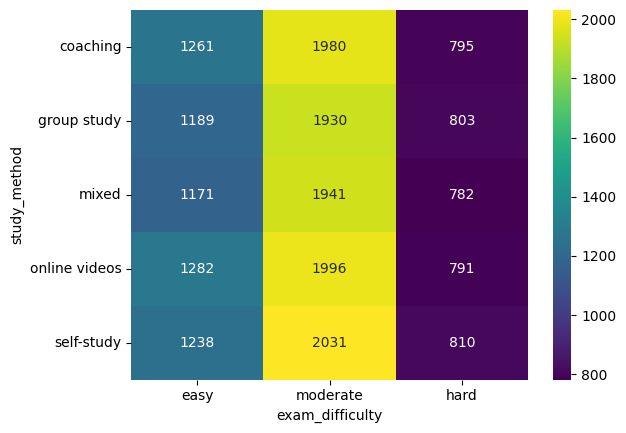

In [564]:
sns.heatmap(method_difficulty, 
            annot=True,     # Show the actual numbers
            fmt='d',        # Format as integers (no decimals)
            cmap='viridis')

From the heat map it is visible that online videos and coaching study method students finds exams easier than rest followde by self study, among these methods also there is only slight variation among number of students,number of students finding exam hard is very much low for students following
mixed methods 782.

<BarContainer object of 5 artists>

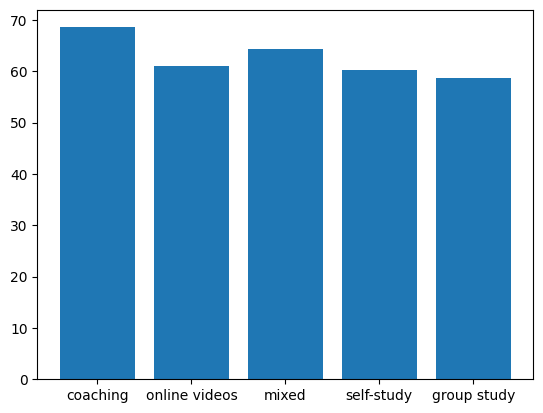

In [565]:
plt.bar(df["study_method"].unique(),df.groupby("study_method",as_index=True)["exam_score"].mean())

From the bar plot average score of students following "coaching" method is higher compared to others.Lowest avergae score obtained by "group study method"

Prediction 

In [566]:
y=df["exam_score"]

In [567]:
df.drop(["exam_score","student_id"],axis=1,inplace=True)
df

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard
1,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate
2,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate
3,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate
4,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate
...,...,...,...,...,...,...,...,...,...,...,...
19995,18,other,bba,6.50,71.3,yes,5.0,good,self-study,low,easy
19996,18,male,b.com,3.71,41.6,no,5.9,average,coaching,medium,moderate
19997,19,other,diploma,7.88,68.2,yes,4.6,poor,group study,low,easy
19998,19,male,bba,4.60,76.3,no,6.1,good,self-study,medium,moderate


In [568]:
from sklearn.compose import ColumnTransformer 

In [590]:
ct=ColumnTransformer(transformers=[
    ('a',OrdinalEncoder(categories=[['poor','average','good']]),['sleep_quality']),
    ('b',OneHotEncoder(sparse_output=False,drop='first'),['study_method']),
    ('c',OrdinalEncoder(categories=[['low','medium','high']]),['facility_rating']),
    ('d',StandardScaler(),['age','study_hours','class_attendance','sleep_hours']),
    ('e',OneHotEncoder(sparse_output=False,drop='first'),['gender']),
    ('f',OrdinalEncoder(categories=[['no','yes']]),['internet_access']),
    ('g',OneHotEncoder(sparse_output=False,drop='first'),['course']),
    ('h',OrdinalEncoder(categories=[["easy","moderate","hard"]]),["exam_difficulty"])
],remainder='passthrough',verbose_feature_names_out=False)
ct.set_output(transform="pandas")

,transformers,"[('a', ...), ('b', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,categories,"[['poor', 'average', ...]]"
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'


In [591]:
transformed_df=ct.fit_transform(df)

In [592]:
transformed_df

,sleep_quality,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study,facility_rating,age,study_hours,class_attendance,sleep_hours,gender_male,gender_other,internet_access,course_b.sc,course_b.tech,course_ba,course_bba,course_bca,course_diploma,exam_difficulty
0,0.0,0.0,0.0,0.0,0.0,0.0,-1.520442,-0.531832,1.324086,0.225999,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,1.0,0.0,0.0,1.0,0.0,1.0,1.106067,-0.276227,-0.301899,-1.390586,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,2.0,0.668315,1.677629,0.392472,0.861085,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,-0.207188,-1.445942,-1.250872,-0.697764,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,-0.207188,-1.350632,0.091578,1.611643,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2.0,0.0,0.0,0.0,1.0,0.0,-1.082691,1.079775,0.074219,-1.159646,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19996,1.0,0.0,0.0,0.0,0.0,1.0,-1.082691,-0.128930,-1.644349,-0.640029,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19997,0.0,1.0,0.0,0.0,0.0,0.0,-0.644939,1.677629,-0.105160,-1.390586,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19998,2.0,0.0,0.0,0.0,1.0,1.0,-0.644939,0.256643,0.363540,-0.524559,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [593]:
xtr,xts,ytr,yts=tts(transformed_df,y,random_state=42,test_size=0.2)      #scaled

In [594]:
from sklearn.linear_model import LinearRegression as LGR

regression_model = LGR()
param_space = {'copy_X': [True,False], 'fit_intercept': [True,False], 
               'n_jobs': [-1,1,5,10,15,None], 'positive': [True,False]}
grid_search = GridSearchCV(regression_model, param_space, cv=5)

grid_search.fit(xtr, ytr)
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}
Best Score: 0.7310240534962761


In [595]:
regression_model = LGR(copy_X= True, fit_intercept= True, n_jobs= -1, positive= False)
regression_model.fit(xtr,ytr)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,-1
,positive,False


In [596]:
y_regr=regression_model.predict(xts)
from sklearn.metrics import r2_score

r2 = r2_score(yts, y_regr)

print(f"Multiple Linear regression : R² score: {r2}")

Multiple Linear regression : R² score: 0.7331071422534658


In [ ]:
from sklearn.linear_model import Ridge

ridge_model=Ridge()

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 50, 100]
}

search = GridSearchCV(
    estimator=ridge_model,          
    param_grid=param_grid,      
    cv=5,                       
    scoring='r2',
    verbose=1
)

search.fit(xtr,ytr)

# 5. Results
best_alpha = search.best_params_['alpha']
best_r2 = search.best_score_  

print(f"Best Alpha: {best_alpha}")
print(f"Best R2: {best_r2:.2f} points")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Alpha: 1
Best R2: 0.73 points


In [598]:
ridge_model=Ridge(alpha=1)
ridge_model.fit(xtr,ytr)
y_ridge=ridge_model.predict(xts)

r2 = r2_score(yts, y_ridge)

print(f"Ridge regression : R² score: {r2}")

Ridge regression : R² score: 0.733109682827108


Using only the numerical variables and neglecting the encoded variables

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=10, random_state=42)

model.fit(xtr, ytr)
y_decs=model.predict(xts)
model.score(xtr,ytr)

0.7688629530167065